# Fútbol bayesiano

Carga de librerías

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

from cmdstanpy import CmdStanModel
from ipywidgets import widgets

Se definen rutas relativas del archivo

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [3]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

Carga en memoria de los datos con transformaciones convenientes

In [4]:
df_ = (
    # --------------------------------------------------- Carga de datos crudos
    pd.read_csv(
        os.path.join(ROOT, config['datos']['raw'])
        ,encoding='latin1')
    # ---------------------------------------------------- Acotar datos a scope
    .query("year > 2018")
    .query("tournament == 'FIFA World Cup qualification'")
    .reset_index(drop=True)
    # --------------------------------------------- Filtrar columnas de interés
    .filter(items=[
        'tournament'
        ,'home_team'
        ,'away_team'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # --------------------------------------- Asignación de columnas computadas
    .assign(
        result = lambda df_: 
            # -1: Away win, 0: Draw, 1: Home win
            (df_.home_team_score - df_.away_team_score).apply(np.sign))
    # -------------------------------------------------------- Filtrar outliers
    .query('home_team_score <= 9')
    .query('away_team_score <= 9')
)

df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 0 to 862
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tournament           855 non-null    object
 1   home_team            855 non-null    object
 2   away_team            855 non-null    object
 3   home_team_continent  855 non-null    object
 4   away_team_continent  855 non-null    object
 5   home_team_score      855 non-null    int64 
 6   away_team_score      855 non-null    int64 
 7   result               855 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 60.1+ KB


Adicionalmente, es necesario construir un catálogo de las regiones a las que pertenecen los distintos equipos, respetando su referencia posicional para que se pueda proporcionar esa información a stan

In [5]:
home_ = (
    df_
    .filter(items=['home_team', 'home_team_continent'])
    .rename(columns={'home_team':'team', 'home_team_continent':'region'}))

away_ = (
    df_
    .filter(items=['away_team', 'away_team_continent'])
    .rename(columns={'away_team':'team', 'away_team_continent':'region'}))

cat_regiones = (
    pd.concat((home_, away_))
    .drop_duplicates('team')
    .assign(
        team = lambda df_: pd.Categorical(df_.team)
        ,region = lambda df_: pd.Categorical(df_.region)
        ,team_code = lambda df_: df_.team.cat.codes + 1
        ,region_code = lambda df_: df_.region.cat.codes + 1
    )
    .sort_values(by='team_code')
    .reset_index(drop=True)
)

cat_regiones.head()

,team,region,team_code,region_code
0,Afghanistan,Asia,1,2
1,Albania,Europe,2,3
2,Algeria,Africa,3,1
3,Andorra,Europe,4,3
4,Angola,Africa,5,1


In [6]:
print(f'Número de equipos: {cat_regiones.team_code.nunique()}')
print(f'Número de regiones: {cat_regiones.region_code.nunique()}')

Número de equipos: 206
Número de regiones: 6


Una vez creado el catálogo, se asignan los códigos creados a las columnas del _dataframe_ de datos inicial. Para ello, del catálogo de equipos y regiones se extrae un diccionario para reemplazar múltiples columnas en los datos.

In [7]:
equipos_ = {}
regiones_ = {}
for row_ in range(cat_regiones.shape[0]):
    equipos_[cat_regiones.loc[row_].team] = cat_regiones.loc[row_].team_code
    regiones_[cat_regiones.loc[row_].region] =  cat_regiones.loc[row_].region_code

df_.home_team = df_.home_team.map(equipos_)
df_.away_team = df_.away_team.map(equipos_)
df_.home_team_continent = df_.home_team_continent.map(regiones_)
df_.away_team_continent = df_.away_team_continent.map(regiones_)

df_.head()

,tournament,home_team,away_team,home_team_continent,away_team_continent,home_team_score,away_team_score,result
0,FIFA World Cup qualification,23,80,2,2,1,0,1
1,FIFA World Cup qualification,34,144,2,2,2,0,1
2,FIFA World Cup qualification,106,16,2,2,0,1,-1
3,FIFA World Cup qualification,115,175,2,2,1,0,1
4,FIFA World Cup qualification,126,29,2,2,2,0,1


# 2. Modelo en STAN

$$y^h\sim Poisson(\theta^h)$$
$$y^a\sim Poisson(\theta^a)$$
$$log(\theta^h) = home_{boost} + attack_{i[h]} - defence_{i[a]}$$
$$log(\theta^a) = attack_{i[a]} - defence_{i[h]}$$

## 2.1 Muestreo

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [8]:
import BFG3000 as bfg

In [10]:
name = 'multinivel'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Ya existe un proyecto con el nombre multinivel


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [11]:
# Compilar el modelo
compile_ = CmdStanModel(
    stan_file=model_
    ,compile=True
)

21:57:47 - cmdstanpy - INFO - compiling stan file /home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel.stan to exe file /home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel
21:58:13 - cmdstanpy - INFO - compiled model executable: /home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel


Se declara un diccionario de datos para proporcionar los datos a stan

In [12]:
stan_data_ = {
    'n_partidos': df_.shape[0]
    ,'n_equipos': cat_regiones.team_code.nunique()
    ,'n_regiones': cat_regiones.region_code.nunique()
    ,'locales': df_.home_team.values
    ,'visitantes': df_.away_team.values
    ,'region_equipo': cat_regiones.region_code.values
    ,'goles_local': df_.home_team_score.values
    ,'goles_visita': df_.away_team_score.values
}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [13]:
fit_ = compile_.sample(
    data=stan_data_
    ,chains=8
    ,seed=202803
    ,iter_warmup=5_000
    ,iter_sampling=5_000
    ,show_progress=True
    ,save_warmup=False
)

21:58:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

21:59:30 - cmdstanpy - INFO - CmdStan done processing.
21:59:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel.stan', line 111, column 4 to column 40)
Exception: offset_multiplier_constrain: multiplier is 0, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel.stan', line 48, column 4 to column 83)
	Exception: offset_multiplier_constrain: multiplier is 0, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel.stan', line 48, column 4 to column 83)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/multinivel/multinivel.stan', line 112, column 4 to column 41)
	Exception: offset_multiplier_constrain: multiplier is 0, but must be positive finite! (in '/home/camm961001/

21:59:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 44 divergent transitions (0.9%)
	Chain 2 had 17 divergent transitions (0.3%)
	Chain 3 had 24 divergent transitions (0.5%)
	Chain 4 had 62 divergent transitions (1.2%)
	Chain 5 had 19 divergent transitions (0.4%)
	Chain 6 had 96 divergent transitions (1.9%)
	Chain 7 had 77 divergent transitions (1.5%)
	Chain 8 had 35 divergent transitions (0.7%)
	Use function "diagnose()" to see further information.


```{python}
fit_path = os.path.join(dir_, name + '_fit_200.pkl')

with open(fit_path, 'rb') as file_:
    pickle.dump(fit_, file_)
file_.close()
```

## 2.2 Resumen de estimadores

In [14]:
summary_ = fit_.summary()
summary_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5974 entries, lp__ to sims_visita[855]
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mean     5974 non-null   float64
 1   MCSE     5974 non-null   float64
 2   StdDev   5974 non-null   float64
 3   5%       5974 non-null   float64
 4   50%      5974 non-null   float64
 5   95%      5974 non-null   float64
 6   N_Eff    5974 non-null   float64
 7   N_Eff/s  5974 non-null   float64
 8   R_hat    5974 non-null   float64
dtypes: float64(9)
memory usage: 466.7+ KB


Función de probabilidad de pertenecer a otro valor

In [15]:
def prob(x):
    out = np.min((
        np.sum(x > 0) / x.shape[0]
        ,np.sum(x < 0) / x.shape[0]))
    return out

In [16]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=True)
chains_ = np.delete(arr=chains_, obj=[1,2,3,4,5,6], axis=1)
chains_.shape

(40000, 5974)

Número de parámetros

In [17]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        prob = np.apply_along_axis(
            func1d=prob
            ,axis=0
            ,arr=chains_)
        ,param_id = lambda df_: df_.param.str.partition('[')[2].str[:-1]
        ,param = lambda df_: df_.param.str.partition('[')[0]
    )
)

summary_vis_.param.value_counts()

param
sims_visita             855
sims_local              855
pred_lambda_visita      855
pred_lambda_local       855
lambda_visita           855
lambda_local            855
region_defensa          206
defensa                 206
ataque                  206
region_ataque           206
base_defensa              6
base_ataque               6
boost_local               1
sigma_defensa_region      1
sigma_ataque_region       1
sigma_defensa             1
sigma_ataque              1
mu_defensa                1
mu_ataque                 1
lp__                      1
Name: count, dtype: int64

### 2.2.1 Resumen de estimadores únicos

In [18]:
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

single_params = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

single_params = single_params[single_params.columns.to_list()[:-1]]
single_params[['param','Mean','5%','50%','95%','R_hat','prob']]

,param,Mean,5%,50%,95%,R_hat,prob
0,lp__,-979.181000,-1008.790000,-978.982000,-950.079000,1.00089,0.000000
1,boost_local,0.257983,0.203350,0.258159,0.312395,1.00017,0.000000
2,mu_ataque,0.000731,-0.163226,0.000934,0.165339,1.00172,0.496425
3,mu_defensa,0.000662,-0.163453,-0.000022,0.166736,1.00160,0.499850
4,sigma_ataque,0.123014,0.007907,0.091491,0.347334,1.00717,0.000000
5,sigma_defensa,0.111015,0.007269,0.079788,0.321051,1.00501,0.000000
6,sigma_ataque_region,0.407177,0.349759,0.405984,0.468038,1.00034,0.000000
7,sigma_defensa_region,0.581343,0.516677,0.579790,0.651352,1.00024,0.000000


### 2.2.2 Resumen de estimadores múltiples

In [19]:
def resumen_estimadores(diagnostico):
    # Datos de visualización
    mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
    vis_ = (
        summary_vis_
        .loc[summary_vis_.param.isin(mask_)]
        .filter(items=['param', diagnostico])
        .assign(
            param = lambda df_: pd.Categorical(df_.param)
        )
    )

    # Especificaciones de figuras
    fig, ax = plt.subplots()

    # Visualizaciones
    ax.scatter(
        x=vis_[diagnostico]
        ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
        ,color=config['visuals']['colors']['verde']
        ,alpha=0.8)
    
    if diagnostico == 'R_hat':
        ax.axvline(
            x=1.05
            ,color=config['visuals']['colors']['rojo']
            ,linestyle='--')
        
    elif diagnostico == 'prob':
        ax.axvline(
            x=0.1
            ,color=config['visuals']['colors']['rojo']
            ,linestyle='--')

    # Anotaciones y estilo
    ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
    ax.set_xlabel(diagnostico)
    ax.set_yticks(
        ticks=vis_.param.cat.codes.unique()
        ,labels=vis_.param.cat.categories)

    plt.show()

In [20]:
widgets.interact(
    resumen_estimadores
    ,diagnostico=widgets.Dropdown(
        options=list(summary_vis_.columns)[1:-1]
        ,description='Resumen'
        ,disabled=False)    
)

interactive(children=(Dropdown(description='Resumen', options=('Mean', 'MCSE', 'StdDev', '5%', '50%', '95%', '…

<function __main__.resumen_estimadores(diagnostico)>

## 2.3 Traza de las cadenas

### 2.3.1 Parámetros simples

In [21]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(5000, 8, 5980)

In [22]:
def traceplot_single_param(param, type):
    # Datos de visualización
    idp_ = fit_.column_names.index(param)
    arr_ = chains_[:, :, idp_]

    # Especificaciones de figura
    plt.figure(figsize=(10,5))

    if type == 'traceplot':
        # Visualizaciones
        for chain in range(arr_.shape[1]):
            plt.plot(
                arr_[:, chain]
                ,color=list(config['visuals']['colors'].values())[chain]
                ,label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Traza de las cadenas, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    if type == 'convergence':
        ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
        ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

        # Visualizaciones
        for chain in range(ergo_.shape[1]):
            plt.plot(
                ergo_[:, chain]
                ,color=list(config['visuals']['colors'].values())[chain]
                ,label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Promedios ergódicos, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    plt.show()

In [23]:
widgets.interact(
    traceplot_single_param
    ,param=widgets.Dropdown(
        options=single_params.param
        ,description='Param'
        ,disabled=False)
    ,type=widgets.Dropdown(
        options=['convergence','traceplot']
        ,description='Type'
        ,disabled=False)       
)

interactive(children=(Dropdown(description='Param', options=('lp__', 'boost_local', 'mu_ataque', 'mu_defensa',…

<function __main__.traceplot_single_param(param, type)>

### 2.3.2 Parámetros múltiples

In [24]:
def traceplot_multi_param(chain, param, type):
    # Extraer índices de parámetros en cadena
    ids_ = (
        summary_vis_
        .loc[summary_vis_['param'] == param]
        .index
        .to_numpy())

    # Filtrar cadenas con índices
    arr_ = chains_[:,chain-1, ids_]

    # Calcular promedios ergódicos
    ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
    ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

    # Especificaciones de figura
    plt.figure(figsize=(10,5))
    
    # Condición de tipo de visulazación
    if type == 'traceplot': plt.plot(arr_, alpha=0.5)
    else: plt.plot(ergo_, alpha=0.5)

    plt.title(
        f'''Visualización {type.upper()} del parámetro {param}, cadena: {chain}'''
        ,loc='left')

    plt.show()

In [25]:
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()

widgets.interact(
    traceplot_multi_param
    ,param=widgets.Dropdown(
        options=mask_
        ,description='Param'
        ,disabled=False)
    ,chain=widgets.IntSlider(
        min=1
        ,max=chains_.shape[1]
        ,step=1
    )
    ,type=widgets.Dropdown(
        options=['convergence','traceplot']
        ,description='Type'
        ,disabled=False)       
)

interactive(children=(IntSlider(value=1, description='chain', max=8, min=1), Dropdown(description='Param', opt…

<function __main__.traceplot_multi_param(chain, param, type)>

## 2.4 Métricas de desempeño

### 2.4.1 WAIC en escala devianza

In [25]:
# Se convierte la salida de cmdstanmodel a objeto de ArViz
inference_data = az.from_cmdstanpy(
    posterior=fit_,
    log_likelihood=['logver_local','logver_visita'])

# WAIC de equipo local en escala devianza
waic_local = az.waic(
    data=inference_data
    ,var_name='logver_local'
    ,scale='deviance')

# WAIC de equipo visitantes en escala devianza
waic_visita = az.waic(
    data=inference_data
    ,var_name='logver_visita'
    ,scale='deviance')

In [26]:
waic_local

Computed from 40000 posterior samples and 855 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  3043.24    67.14
p_waic            1.72        -

In [27]:
waic_visita

Computed from 40000 posterior samples and 855 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  2566.38    74.34
p_waic            0.00        -

### 2.4.2 Comparación de modelos

Las métricas de desempeño de todos los modelos se almacenaron manualmente en un archivo externo llamado `deviance_waic.csv`. Utilizando dicho archiv, se puede hacer la siguiente visualización para comparar los modelos:

In [25]:
waic_df = (
    pd.read_csv(
        os.path.join(ROOT, config['datos']['waic']))
    .assign(
        model = lambda df_: pd.Categorical(df_.model)
        ,team_type = lambda df_: pd.Categorical(df_.team_type)
    )
)
waic_df

,model,team_type,deviance_waic,se,p_r2
0,constantes,local,3043.21,67.14,NaN
1,constantes,visita,2566.38,74.34,NaN
2,independientes,local,2600.40,46.76,NaN
3,independientes,visita,2258.58,40.99,NaN
4,jerarquico,local,2602.52,44.39,NaN
5,jerarquico,visita,2200.48,40.89,NaN
6,multinivel,local,2602.91,44.37,NaN
7,multinivel,visita,2200.54,40.81,NaN


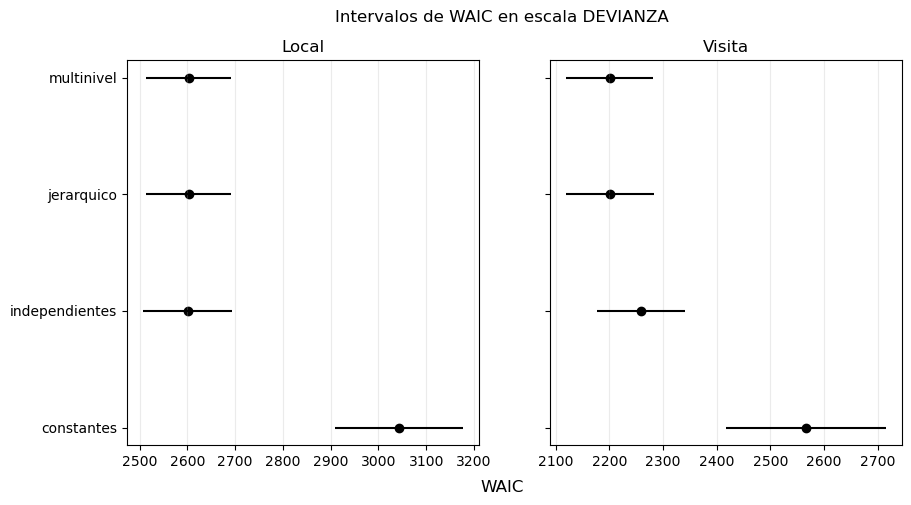

In [26]:
# Especificaciones de figura
fig = plt.figure(figsize=(10,5))
gs = plt.GridSpec(nrows=1, ncols=2, figure=fig, hspace=0.2)

ax1 = fig.add_subplot(gs[0])
tipo = 'local'
for modelo in waic_df.model.cat.categories:
    vis_ = (
        waic_df
        .query(f"model=='{modelo}'")
        .query(f"team_type=='{tipo}'"))

    # Visualizaciones
    ax1.scatter(
        x=vis_.deviance_waic
        ,y=vis_.model.cat.codes
        ,color='black')
    ax1.hlines(
        y=vis_.model.cat.codes
        ,xmin=[vis_.deviance_waic - 2*vis_.se]
        ,xmax=[vis_.deviance_waic + 2*vis_.se]
        ,color='black')
    
ax1.set_title(tipo.title())
ax1.set_yticks(ticks=waic_df.model.cat.codes.unique(), labels=waic_df.model.cat.categories)
ax1.grid(alpha=0.25, axis='x')

ax2 = fig.add_subplot(gs[1])
tipo = 'visita'
for modelo in waic_df.model.cat.categories:
    vis_ = (
        waic_df
        .query(f"model=='{modelo}'")
        .query(f"team_type=='{tipo}'"))

    # Visualizaciones
    ax2.scatter(
        x=vis_.deviance_waic
        ,y=vis_.model.cat.codes
        ,color='black')
    ax2.hlines(
        y=vis_.model.cat.codes
        ,xmin=[vis_.deviance_waic - 2*vis_.se]
        ,xmax=[vis_.deviance_waic + 2*vis_.se]
        ,color='black')
    
ax2.set_title(tipo.title())
ax2.set_yticks(ticks=waic_df.model.cat.codes.unique(), labels='')
ax2.grid(alpha=0.25, axis='x')

fig.suptitle('Intervalos de WAIC en escala DEVIANZA')
fig.supxlabel('WAIC')

plt.show()

# 3. Inferencia

## 3.1 Habilidades por equipo

### 3.1.1 Habilidad de las regiones (Multinivel)

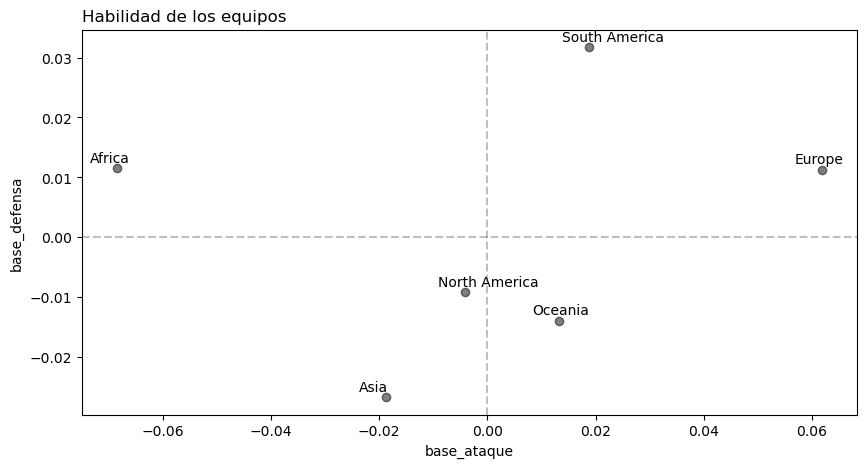

In [61]:
# Datos de visualización
ataque_param = 'base_ataque'
defensa_param = 'base_defensa'

vis_ = (
    summary_vis_
    .loc[summary_vis_['param'].isin([ataque_param, defensa_param]) ]
    .reset_index(drop=True))

regiones = ['Africa','Asia','Oceania','North America','Europe','South America']

# Especificaciones de figura
plt.figure(figsize=(10,5))

# Visualizaciones
plt.scatter(
    x=vis_.query(f"param=='{ataque_param}'").Mean
    ,y=vis_.query(f"param=='{defensa_param}'").Mean
    ,color='black'
    ,alpha=0.5)
plt.axvline(x=0, color='black', alpha=0.25, linestyle='--')
plt.axhline(y=0, color='black', alpha=0.25, linestyle='--')

# Anotaciones y estilo
plt.title('Habilidad de los equipos', loc='left')
plt.xlabel(ataque_param)
plt.ylabel(defensa_param)

for idx, region in enumerate(regiones):
    X = vis_.query(f"param=='{ataque_param}'").Mean.reset_index(drop=True)[idx]
    Y = vis_.query(f"param=='{defensa_param}'").Mean.reset_index(drop=True)[idx]
    plt.text(
        x=X - 0.005
        ,y=Y + 0.001
        ,s=region.title()
    )

plt.show()

### 3.1.2 Habilidad de los equipos

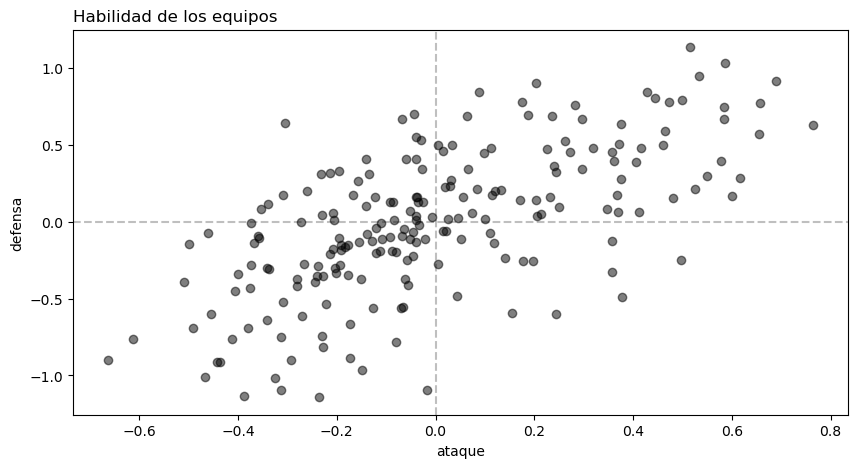

In [27]:
# Datos de visualización
ataque_param = 'ataque'
defensa_param = 'defensa'

vis_ = (
    summary_vis_
    .loc[summary_vis_['param'].isin([ataque_param, defensa_param]) ]
    .reset_index(drop=True)
)

# Especificaciones de figura
plt.figure(figsize=(10,5))

# Visualizaciones
plt.scatter(
    x=vis_.query(f"param=='{ataque_param}'").Mean
    ,y=vis_.query(f"param=='{defensa_param}'").Mean
    ,color='black'
    ,alpha=0.5)
plt.axvline(x=0, color='black', alpha=0.25, linestyle='--')
plt.axhline(y=0, color='black', alpha=0.25, linestyle='--')

# Anotaciones y estilo
plt.title('Habilidad de los equipos', loc='left')
plt.xlabel(ataque_param)
plt.ylabel(defensa_param)

plt.show()

Verificar restricción de suma cero

In [33]:
(
    summary_vis_
    .loc[summary_vis_['param'] == 'defensa']
    .reset_index(drop=True)
    .Mean
    .sum()
)

1.0749999999060122e-05

# 4. Predicciones

## 4.1 Intervalos de predicción

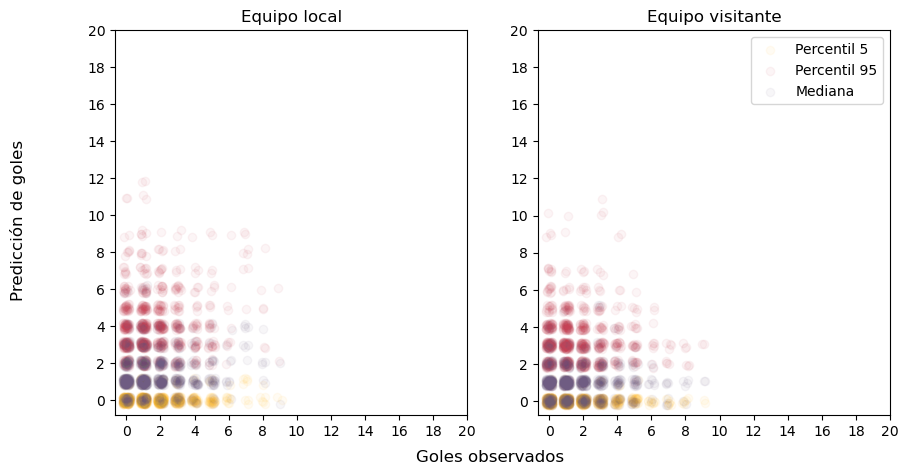

In [52]:
# Especificaciones de figura
fig = plt.figure(figsize=(10,5))
gs = plt.GridSpec(nrows=1, ncols=2, figure=fig, wspace=0.2, hspace=0.2)

facet_dict = {
    'params': ['sims_local', 'sims_visita']
    ,'title': ['Equipo local', 'Equipo visitante']
}

# Factor de ruido
k = 0.2

for idx_ in range(len(facet_dict)):
    # Datos de visualización
    vis_ = (
        summary_vis_
        .loc[summary_vis_['param'] == facet_dict['params'][idx_]][['5%','50%','95%']]
        .reset_index(drop=True)
        .join(df_.home_team_score)
        .rename(columns={
            '5%': 'p_05'
            ,'50%': 'p_50'
            ,'95%': 'p_95'}))

    # Visualizaciones
    ax = fig.add_subplot(gs[idx_])
    ax.scatter(
        x=vis_.home_team_score + np.random.uniform(low=-k, high=k, size=vis_.shape[0])
        ,y=vis_.p_05 + np.random.uniform(low=-k, high=k, size=vis_.shape[0])
        ,color=config['visuals']['colors']['amarillo']
        ,alpha=0.05
        ,label='Percentil 5')
    ax.scatter(
        x=vis_.home_team_score + np.random.uniform(low=-k, high=k, size=vis_.shape[0])
        ,y=vis_.p_95 + np.random.uniform(low=-k, high=k, size=vis_.shape[0])
        ,color=config['visuals']['colors']['rojo']
        ,alpha=0.05
        ,label='Percentil 95')
    ax.scatter(
        x=vis_.home_team_score + np.random.uniform(low=-k, high=k, size=vis_.shape[0])
        ,y=vis_.p_50 + np.random.uniform(low=-k, high=k, size=vis_.shape[0])
        ,color=config['visuals']['colors']['morado']
        ,alpha=0.05
        ,label='Mediana')
    #plt.plot(vis_.home_team_score, vis_.home_team_score, color='black', alpha=0.25)


    # Anotaciones y estilo
    ax.set_title(facet_dict['title'][idx_])
    ax.set_xticks(np.arange(0,21,2))
    ax.set_yticks(np.arange(0,21,2))

fig.supxlabel('Goles observados')
fig.supylabel('Predicción de goles')
ax.legend()

plt.show()

## 4.2 Distribuciones de la predictiva posterior

In [53]:
preds = {
    'preds_home':(
        summary_vis_
        .loc[summary_vis_.param == 'sims_local']
        .Mean
        .apply(int)).values
    ,'preds_away':(
    summary_vis_
    .loc[summary_vis_.param == 'sims_visita']
    .Mean
    .apply(int)).values
}

preds = (
    pd.DataFrame(preds)
    .assign(
        # -1: Away win, 0: Draw, 1: Home win
        result = lambda df_:
            (df_.preds_home - df_.preds_away).apply(np.sign)
    )
)

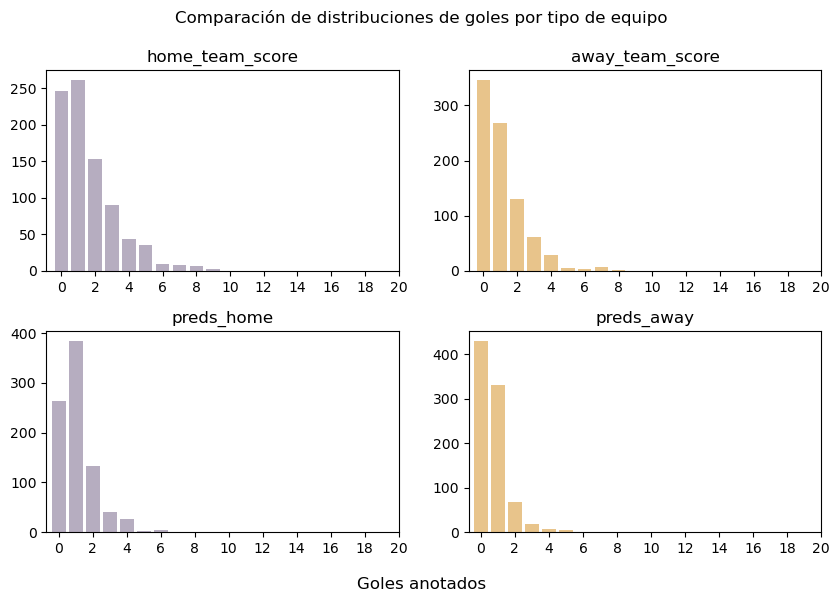

In [54]:
# Datos de visualización
vis_ = pd.concat(
    (df_[['home_team_score','away_team_score']],preds[['preds_home','preds_away']])
    ,axis=1)

# Especificaciones de figura
fig = plt.figure(figsize=(10,6))
gs = plt.GridSpec(nrows=2, ncols=2, figure=fig, wspace=0.2, hspace=0.3)

for idx_, col_ in enumerate(vis_.columns):
    # Agrager elemento de figura
    ax = fig.add_subplot(gs[idx_])

    # Visualizaciones
    ax.bar(
        x=vis_[col_].value_counts().index
        ,height=vis_[col_].value_counts().values
        ,color=list(config['visuals']['colors'].values())[idx_%2 + 4]
        ,alpha=0.5)
    
    # Anotaciones y estilo locales
    ax.set_title(col_)
    ax.set_xticks(np.arange(0,21,2))

# Anotaciones globales
fig.suptitle('Comparación de distribuciones de goles por tipo de equipo')
fig.supxlabel('Goles anotados')

plt.show()
    

## 4.3 Pseudo-$R^2$

In [55]:
(
    pd.concat(
        (preds.preds_home, df_.home_team_score)
        ,axis=1)
    .corr()
)**2

,preds_home,home_team_score
preds_home,1.000000,0.015862
home_team_score,0.015862,1.000000


In [56]:
(
    pd.concat(
        (preds.preds_away, df_.away_team_score)
        ,axis=1)
    .corr()
)**2

,preds_away,away_team_score
preds_away,1.000000,0.015015
away_team_score,0.015015,1.000000
